In [1]:
import pandas as pd
import numpy as np
#import random
#import copy
import matplotlib.pyplot as plt
#import xgboost as xgb
from sklearn.ensemble import IsolationForest
#from sklearn.neighbors import LocalOutlierFactor
#from sklearn.preprocessing import RobustScaler
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import metrics
from catboost import CatBoostRegressor, Pool, cv

# Загрузим файл с признаками

In [4]:
features = pd.read_excel('C:\\Users\\dgalk\\ml.ai\\shad_final_project\\features_rest_Russia.xlsx')

# Возьмем в рассмотрение пока 1-ую корзину

In [3]:
print("Кол-во объектов basket1: {0}".format(features["Basket1"].dropna().size))

Кол-во объектов basket1: 9947


Удалим из нее объекты, где Apharm = 1 и Nan

In [30]:
bask1 = features["Basket1"][features.Apharm == 0].dropna()
print("Итоговое кол-во объектов без Apharm=1: {0}".format(bask1.size))

Итоговое кол-во объектов без Apharm=1: 9217


Т.е. порядка 700 убрали из рассмотрения

Посмотрим на гистограмму распределения

In [5]:
def plot_hist(data, title=''):
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    data.plot.hist(grid=True, bins=20, ax=ax, rwidth=0.9, color='#607c8e')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel('Частоты', fontsize=20)
    ax.set_xlabel('Объем корзины', fontsize=20)  

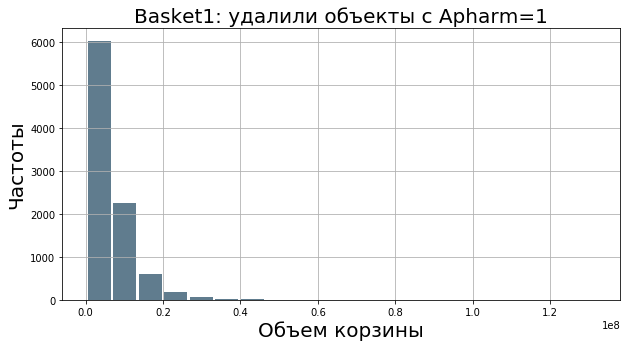

In [6]:
plot_hist(bask1, 'Basket1: удалили объекты с Apharm=1')

Построим график basket1 по возрастанию значений 

In [19]:
def plot_one_graphic_sorted(y, figsize=(10,5), linewidth=4, color='tab:brown', label=''):
    indices = np.argsort(y)
    x_plt = np.arange(0, y.size)
    y_plt = y.iloc[indices]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x_plt, y_plt, color=color, linewidth=linewidth, label=label)
    ax.grid(linestyle='--')
    ax.legend()

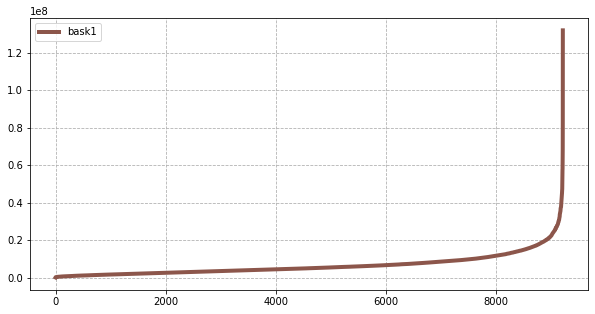

In [20]:
plot_one_graphic_sorted(bask1, label='bask1')

Собственно, видим то, что и на гистаграмме: ярко выраженный хвост с большими значениями. 

# Отсеивание признаков с помощью IsolationForest

*Было рассмотрено несколько вариантов отсеивания признаков. Не только с помощью **IsolationForest**. Он дал лучше результат, поэтому в данном ноутбуке только он будет рассмотрен*

Посмотрим, при каком random_state меньше всего и больше всего признаков отсеивается

In [112]:
rand_state_list = []

for random_state_ in range(0, 300):
    iso_forest = IsolationForest(random_state=random_state_).fit_predict(np.array(bask1).reshape(-1, 1))
    rand_state_list.append(np.abs(iso_forest[np.where(iso_forest == -1)].sum()))
    
rand_state_min = min((val, idx) for idx, val in enumerate(rand_state_list))
rand_state_max = max((val, idx) for idx, val in enumerate(rand_state_list))

print("Min: {0} --- {1}".format(rand_state_min[1], rand_state_min[0]))
print("Max: {0} --- {1}".format(rand_state_max[1], rand_state_max[0]))

Min: 229 --- 1361
Max: 32 --- 2328


*Далее будем рассматривать только **Min значение**, т.к. он в процессе моделирования получше результаты показал*

In [113]:
# минимум
iso_forest = IsolationForest(random_state=229).fit_predict(np.array(bask1).reshape(-1, 1))
bask1_isoforest_min = bask1.iloc[np.where(iso_forest == 1)]
print("Итоговое кол-во объектов: {0}".format(bask1_isoforest_min.size))

Итоговое кол-во объектов: 7856


Посмотрим на то, что построили

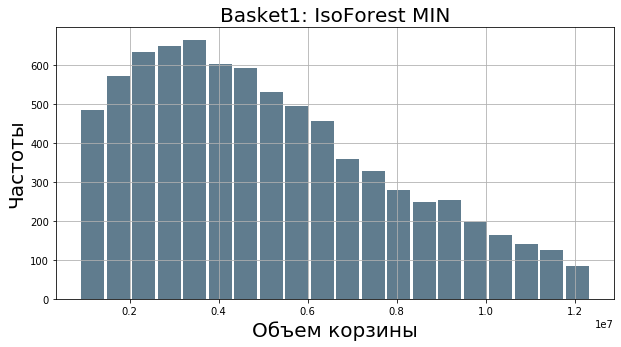

In [114]:
plot_hist(bask1_isoforest_min, title='Basket1: IsoForest MIN')

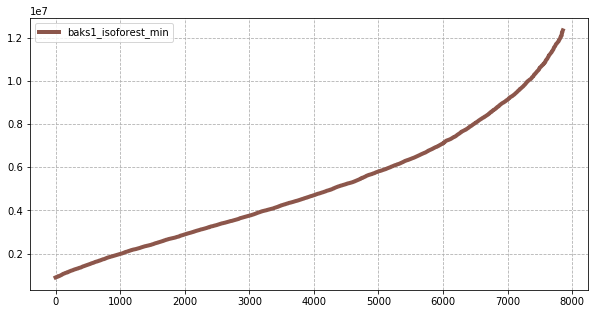

In [115]:
plot_one_graphic_sorted(bask1_isoforest_min, label='baks1_isoforest_min')

# Признаки, которые будем рассматривать

Полный список

In [151]:
col_full = ['BrandCodes', 'BrickCode', 
           'Cash', 'Card', 'Internet', 'Bank',
           'population', 'VRP', 
           'NumHos','NumAmb', 'NumPhc',
           'APT', 'PCP', 'PHK', 'PHN', 'PST',
           'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14',
           'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 
           'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14',
           'top_sales_84', 'top_sales_41', 'top_sales_7', 'top_sales_9', 'top_sales_10',
           'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39',
           'Metro_dist', 'Metro_num',   
           'АО', 'Респ', 'край', 'обл', 
           'аллея', 'б-р', 'городок',
           'дор', 'заезд', 'кв-л', 'км', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк',
           'пер', 'пл', 'пр-кт', 'проезд', 'просека', 'рзд', 'ряды', 'сл', 'спуск',
           'тер', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 
           'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean',
           'weekdays_work_time',
           'weekend_work_time',  
           'is_work_time_almost_24_7',
           #'uniq_sku_mean_median3', 'sell_mean_median3', 'avg_sell_sku_median3',
           'uniq_sku_mean_summer_median3', 
           'uniq_sku_mean_autumn_median3',
           'uniq_sku_mean_winter_median3', 
           'uniq_sku_mean_spring_median3',
           'sell_mean_summer_median3', 
           'sell_mean_autumn_median3', 
           'sell_mean_winter_median3', 
           'sell_mean_spring_median3',
           'avg_sell_sku_summer_median3',
           'avg_sell_sku_autumn_median3',
           'avg_sell_sku_winter_median3',
           'avg_sell_sku_spring_median3',
           'num_pharm', 'region_popul', 'soul_on_pharm',
           'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 
]

# Первый baseline

In [152]:
def get_XY(data, col, random_state=123):
    
    X = features.loc[data.index, col]
    y = data[X.index]
    
    X_train, X_test, y_train, y_test = \
                train_test_split(X, y, 
                                 test_size=0.2,
                                 random_state=random_state,
                                 shuffle=True)
    
    return X_train, X_test, y_train, y_test

In [153]:
bask1_median = np.round(bask1_isoforest_min.median())
print("Медиана bask1_isoforest_min: {0}".format(bask1_median))

Медиана bask1_isoforest_min: 4629219.0


In [154]:
def print_best_test_results(model):
    print("====================")
    print("    test-results")
    print("====================")
    
    print("RMSE:\t{0}".format(np.round(model.get_best_score()['validation']['RMSE'])))
    print("MAE:\t{0} ({1}%)".format(np.round(model.get_best_score()['validation']['MAE']), 
                                   np.round(model.get_best_score()['validation']['MAE'] / bask1_median * 100)))
    print("R2:\t{0}".format(np.round(model.get_best_score()['validation']['R2'], 3)))
    print("MAPE:\t{0}".format(np.round(model.get_best_score()['validation']['MAPE'], 3)))

In [155]:
def plot_train_test_metrics(model):
    x_plt = np.arange(1, model.get_params()['iterations'] + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.plot(x_plt, model.evals_result_['learn']['RMSE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['RMSE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('RMSE', loc='right', fontsize=12)
    plt.legend()

    plt.subplot(222)
    plt.plot(x_plt, model.evals_result_['learn']['MAE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['MAE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('MAE', loc='right', fontsize=12)
    plt.legend()
    
    plt.subplot(223)
    plt.plot(x_plt, model.evals_result_['learn']['R2'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['R2'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('R2', loc='right', fontsize=12)
    plt.legend()
    
    plt.subplot(224)
    plt.plot(x_plt, model.evals_result_['learn']['MAPE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['MAPE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('MAPE', loc='right', fontsize=12)
    plt.legend()
    
    plt.show()

In [156]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_full, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print_best_test_results(model)

    test-results
RMSE:	1759694.0
MAE:	1273217.0 (28.0%)
R2:	0.597
MAPE:	0.334


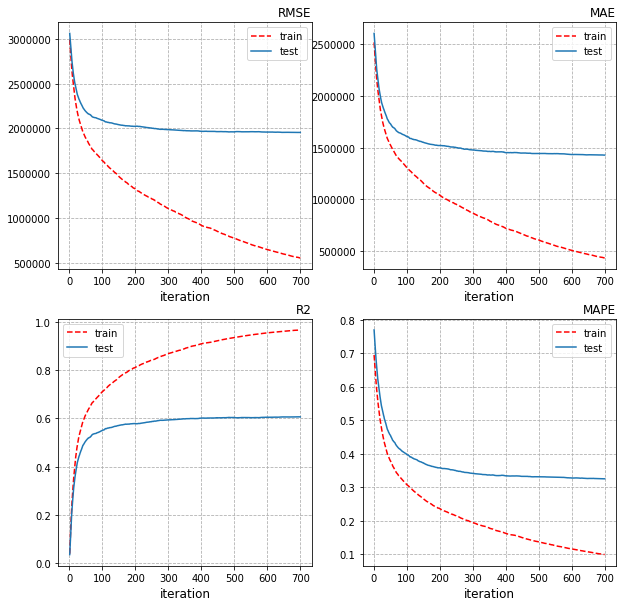

In [245]:
plot_train_test_metrics(model)

# Gridsearch

In [97]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_full, random_state=123)

model = CatBoostRegressor(custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

grid = {'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'depth': [5, 6, 7, 8],
        'l2_leaf_reg': [0, 1, 2, 3, 4]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train,
                                       cv=5,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1843387.107
bestIteration = 973


bestTest = 1843694.254
bestIteration = 988


bestTest = 1835239.206
bestIteration = 997


bestTest = 1820992.455
bestIteration = 975


bestTest = 1845144.246
bestIteration = 999


bestTest = 1831719.529
bestIteration = 994


bestTest = 1829936.922
bestIteration = 999


bestTest = 1835164.873
bestIteration = 720


bestTest = 1859805.505
bestIteration = 999


bestTest = 1848089.73
bestIteration = 995


bestTest = 1824640.889
bestIteration = 931


bestTest = 1841743.985
bestIteration = 721


bestTest = 1859704.651
bestIteration = 999


bestTest = 1854619.75
bestIteration = 996


bestTest = 1831301.344
bestIteration = 963


bestTest = 1832319.971
bestIteration = 949


bestTest = 1861902.03
bestIteration = 997


bestTest = 1836991.15
bestIteration = 998


bestTest = 1820873.58
bestIteration = 999


bestTest = 1827576.205
bestIteration = 942


bestTest = 1817514.127
bestIteration = 988


bestTest = 1833163.081
bestIteration = 993


bestTest = 182

KeyboardInterrupt: 

Полученные параметры (возьмем такие):

<li>depth = 7
<li>learning_rate = 0.05
<li>l2_leaf_reg = 3
    
Посмотрим качество на тесте и кросс-валидации при этих параметрах

In [225]:
def cv_res(X, y, iterations=1500, depth=7, lr=0.05, l2=3):
    cv_dataset = Pool(data=X, label=y)

    params = {"iterations": iterations,
              "depth": depth,
              "learning_rate": lr,
              "l2_leaf_reg": l2,
              "loss_function": "RMSE",
              "custom_metric": ['R2', 'RMSE', 'MAE', 'MAPE'],
              "verbose": False}

    scores = cv(cv_dataset,
                params,
                fold_count=5)
    
    index_min_rmse = np.argmin(scores['test-RMSE-mean'])

    print("====================")
    print("  cross-validation")
    print("====================")

    rmse_mean = scores['test-RMSE-mean'][index_min_rmse]
    rmse_std = scores['test-RMSE-std'][index_min_rmse]
    print("RMSE:\t{0} +- {1}".format(np.round(rmse_mean), np.round(2 * rmse_std)))

    mae_mean = scores['test-MAE-mean'][index_min_rmse]
    mae_std = scores['test-MAE-std'][index_min_rmse]
    print("MAE:\t{0} +- {1}\t({2} %)".format(np.round(mae_mean), np.round(2 * mae_std),
         np.round(mae_mean / bask1_median * 100)))

    r2_mean = scores['test-R2-mean'][index_min_rmse]
    r2_std = scores['test-R2-std'][index_min_rmse]
    print("R2:\t{0} +- {1}".format(np.round(r2_mean, 3), np.round(2 * r2_std, 3)))

    mape_mean = scores['test-MAPE-mean'][index_min_rmse]
    mape_std = scores['test-MAPE-std'][index_min_rmse]
    print("MAPE:\t{0} +- {1}".format(np.round(mape_mean, 3), np.round(2 * mape_std, 3)))
    
    return index_min_rmse

In [229]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_full, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print_best_test_results(model)

    test-results
RMSE:	1746661.0
MAE:	1271616.0 (27.0%)
R2:	0.603
MAPE:	0.332


In [160]:
cv_res(X_train, y_train)

  cross-validation
RMSE:	1755343.0 +- 46683.0
MAE:	1298389.0 +- 22007.0	(28.0 %)
R2:	0.602 +- 0.019
MAPE:	0.341 +- 0.018


Примерно одинаково

Посмотрим на значимость признаков

In [161]:
def get_and_draw_importances(X_train, importances, figsize=(10,25)):
  indices = np.argsort(importances)
  plt.figure(figsize=figsize)
  plt.title("Feature importances")
  plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")
  plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
  plt.ylim([-1, X_train.shape[1]])
  plt.show()
  return X_train.columns[indices]

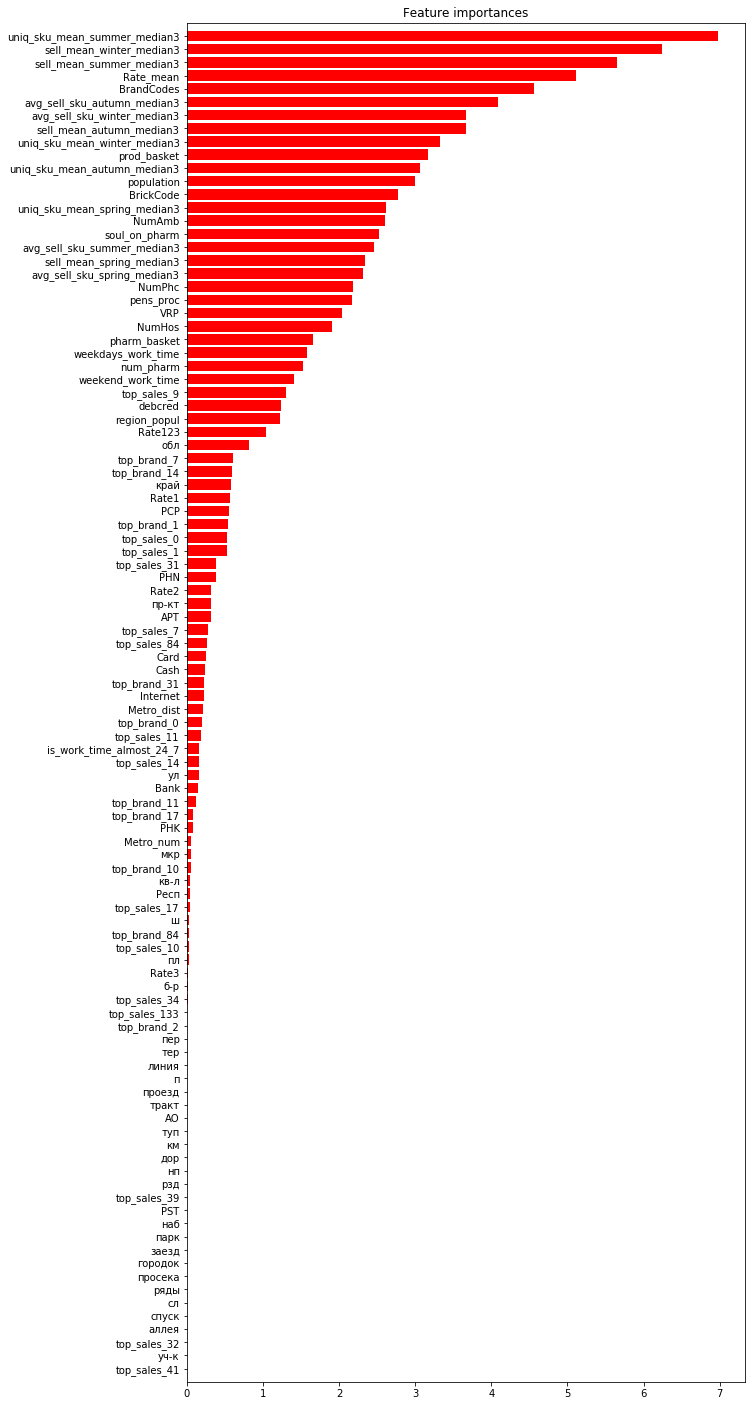

In [163]:
importances_ = get_and_draw_importances(X_train, model.feature_importances_)

# Уменьшение кол-ва признаков

**Уменьшим до 50**

In [165]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_full, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=50, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_50_features = [col_full[i] for i, b in enumerate(selector.support_) if b]
print(col_50_features)

['BrandCodes', 'BrickCode', 'Cash', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHN', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_sales_1', 'top_sales_0', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'Metro_dist', 'край', 'обл', 'пр-кт', 'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']


Ну и чтобы не перезапускать в след. раз

In [166]:
col_50_features = ['BrandCodes', 'BrickCode', 'Cash', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHN', 
                   'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 
                   'top_sales_1', 'top_sales_0', 'top_sales_14', 'top_sales_7', 'top_sales_9', 
                   'Metro_dist', 'край', 'обл', 'пр-кт', 
                   'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'region_popul', 'soul_on_pharm', 
                   'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 70**

In [222]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_full, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=70, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_70_features = [col_full[i] for i, b in enumerate(selector.support_) if b]
print(col_70_features)

['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHK', 'PHN', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_17', 'Metro_dist', 'Metro_num', 'Респ', 'край', 'обл', 'кв-л', 'мкр', 'пр-кт', 'ул', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3'

In [223]:
col_70_features = ['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 
                   'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 
                   'APT', 'PCP', 'PHK', 'PHN', 
                   'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 
                   'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 
                   'top_brand_17', 'top_sales_1', 'top_sales_0', 'top_sales_11', 
                   'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 
                   'top_sales_9', 'top_sales_10', 'top_sales_17', 
                   'Metro_dist', 'Metro_num', 
                   'Респ', 'край', 'обл', 'кв-л', 'мкр', 'пр-кт', 'ул', 'ш', 
                   'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 
                   'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 40**

In [167]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_50_features, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=40, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_40_features = [col_50_features[i] for i, b in enumerate(selector.support_) if b]
print(col_40_features)

['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'top_brand_1', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_sales_1', 'top_sales_0', 'top_sales_9', 'край', 'обл', 'Rate123', 'Rate1', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']


In [168]:
col_40_features = ['BrandCodes', 'BrickCode', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 
                   'top_brand_1', 'top_brand_7', 'top_brand_14', 'top_brand_31', 
                   'top_sales_1', 'top_sales_0', 'top_sales_9', 
                   'край', 'обл', 'Rate123', 'Rate1', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 
                   'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 35**

In [169]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_40_features, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=35, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_35_features = [col_40_features[i] for i, b in enumerate(selector.support_) if b]
print(col_35_features)

['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'top_brand_7', 'top_sales_1', 'top_sales_9', 'обл', 'Rate123', 'Rate1', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']


In [170]:
col_35_features = ['BrandCodes', 'BrickCode', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 
                   'top_brand_7', 'top_sales_1', 'top_sales_9', 
                   'обл', 'Rate123', 'Rate1', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 
                   'pens_proc', 'prod_basket', 'pharm_basket']

**Уменьшим до 30**

In [171]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_35_features, random_state=123)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          verbose=0)

selector = RFE(model, n_features_to_select=30, step=1, verbose=0)
selector = selector.fit(X_train, y_train)

col_30_features = [col_35_features[i] for i, b in enumerate(selector.support_) if b]
print(col_30_features)

['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'top_sales_9', 'Rate123', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']


In [172]:
col_30_features = ['BrandCodes', 'BrickCode', 'population', 'VRP', 
                   'NumHos', 'NumAmb', 'NumPhc', 'top_sales_9', 
                   'Rate123', 'Rate_mean', 
                   'weekdays_work_time', 'weekend_work_time', 
                   'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 
                   'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
                   'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
                   'sell_mean_winter_median3', 'sell_mean_spring_median3', 
                   'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
                   'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 
                   'num_pharm', 'soul_on_pharm', 'debcred', 
                   'pens_proc', 'prod_basket', 'pharm_basket']

**Попробуем полученный сокращенный сет признаков с теми же гиперпараметрами**

In [226]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_70_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("70 признаков")
print_best_test_results(model)

best_iter_ = cv_res(X_train, y_train)

70 признаков
    test-results
RMSE:	1750605.0
MAE:	1260153.0 (27.0%)
R2:	0.601
MAPE:	0.33
  cross-validation
RMSE:	1750282.0 +- 50964.0
MAE:	1292616.0 +- 29194.0	(28.0 %)
R2:	0.605 +- 0.018
MAPE:	0.338 +- 0.022


In [180]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_50_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("50 признаков")
print_best_test_results(model)

50 признаков
    test-results
RMSE:	1737773.0
MAE:	1254739.0 (27.0%)
R2:	0.607
MAPE:	0.327


In [174]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_40_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("40 признаков")
print_best_test_results(model)

40 признаков
    test-results
RMSE:	1758389.0
MAE:	1271921.0 (27.0%)
R2:	0.597
MAPE:	0.333


In [175]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_35_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("35 признаков")
print_best_test_results(model)

35 признаков
    test-results
RMSE:	1753977.0
MAE:	1269039.0 (27.0%)
R2:	0.599
MAPE:	0.333


In [176]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_30_features, random_state=123)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=2000,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print("30 признаков")
print_best_test_results(model)

30 признаков
    test-results
RMSE:	1755043.0
MAE:	1269315.0 (27.0%)
R2:	0.599
MAPE:	0.331


При 50 признаках лучше всего результат. Посмотрим теперь, что кросс-валидация дает на 50 и 30 признаках

In [177]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_50_features, random_state=123)
best_iter_ = cv_res(X_train, y_train)

  cross-validation
RMSE:	1751195.0 +- 48660.0
MAE:	1295656.0 +- 35854.0	(28.0 %)
R2:	0.604 +- 0.018
MAPE:	0.341 +- 0.019


In [179]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_30_features, random_state=123)
best_iter_ = cv_res(X_train, y_train)

  cross-validation
RMSE:	1764998.0 +- 80450.0
MAE:	1308398.0 +- 53094.0	(28.0 %)
R2:	0.598 +- 0.032
MAPE:	0.344 +- 0.019


> *Остановимся на всех признаках, т.к. в противном случае пока растет std на кросс-валидации*

**Построим график теста и предсказания**

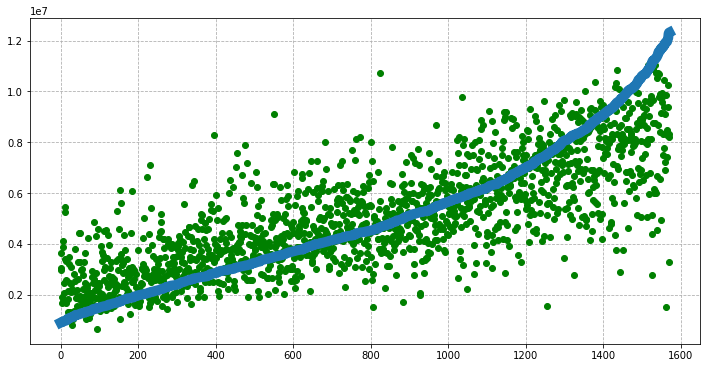

In [232]:
y_pred = model.predict(X_test)
indices = np.argsort(y_test)

x_plt = np.arange(0, y_test.size)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test.iloc[indices], color='tab:blue', linewidth=10)
ax.grid(linestyle='--')

# Теперь возьмем только города миллионники

In [233]:
index_big_cities = []
for i, reg in enumerate(features.OKBrickL3):
    if "новосибирск г" in reg.lower() and "новосибирская" in reg.lower():
        index_big_cities.append(i)
    if "екатеринбург" in reg.lower():
        index_big_cities.append(i)
    if "нижний новгород" in reg.lower():
        index_big_cities.append(i)
    if "казань" in reg.lower():
        index_big_cities.append(i)
    if "челябинск г" in reg.lower() and "челябинская" in reg.lower():
        index_big_cities.append(i)
    if "омск г" in reg.lower() and "омская" in reg.lower() and "томск" not in reg.lower():
        index_big_cities.append(i)
    if "самара" in reg.lower():
        index_big_cities.append(i)
    if "ростов-на-дону" in reg.lower():
        index_big_cities.append(i)
    if "уфа г" in reg.lower():
        index_big_cities.append(i)
    if "красноярск г" in reg.lower():
        index_big_cities.append(i)
    if "воронеж г" in reg.lower() and "нововоронеж" not in reg.lower():
        index_big_cities.append(i)
    if "пермь" in reg.lower():
        index_big_cities.append(i)
    if "волгоград г" in reg.lower():
        index_big_cities.append(i) 
        
print("Кол-во городов-миллионников: {}".format(len(index_big_cities)))

Кол-во городов-миллионников: 8477


In [234]:
bask1_big_cities = features.loc[index_big_cities, "Basket1"][features.Apharm == 0].dropna()
print("Кол-во объектов в выборке: {0}".format(bask1_big_cities.size))

Кол-во объектов в выборке: 1638


Итого осталось: 1403


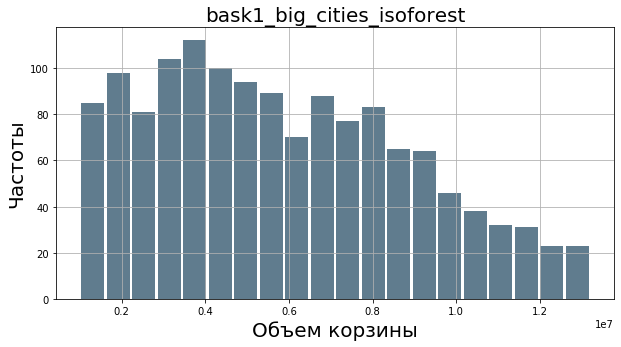

In [236]:
iso_forest = IsolationForest(random_state=64).fit_predict(np.array(bask1_big_cities).reshape(-1, 1))
bask1_big_cities_isoforest = bask1_big_cities.iloc[np.where(iso_forest == 1)]
print("Итого осталось: {0}".format(bask1_big_cities_isoforest.size))
plot_hist(bask1_big_cities_isoforest, 'bask1_big_cities_isoforest')

In [237]:
bask1_median = bask1_big_cities_isoforest.median()
print("bask1_big_cities_isoforest медиана: {0}".format(np.round(bask1_median)))

bask1_big_cities_isoforest медиана: 5428352.0


In [239]:
X_train, X_test, y_train, y_test = get_XY(bask1_big_cities_isoforest, col_full, random_state=5)

eval_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(iterations=1500,
                          depth=7,
                          learning_rate=0.05,
                          l2_leaf_reg=3,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

print_best_test_results(model)

best_iter_ = cv_res(X_train, y_train)

    test-results
RMSE:	1954119.0
MAE:	1419459.0 (26.0%)
R2:	0.607
MAPE:	0.322
  cross-validation
RMSE:	1947488.0 +- 306810.0
MAE:	1474506.0 +- 240488.0	(27.0 %)
R2:	0.59 +- 0.053
MAPE:	0.326 +- 0.064


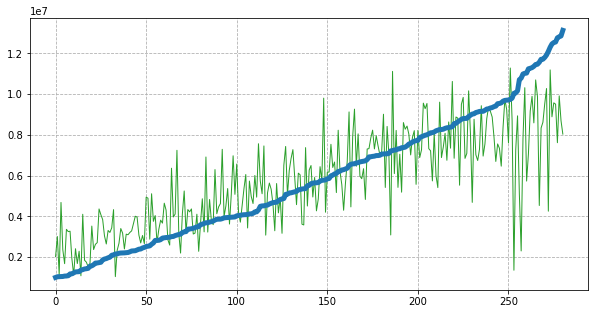

In [244]:
y_pred = model.predict(X_test)
indices = np.argsort(y_test)

x_plt = np.arange(0, y_test.size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], color='tab:green', linewidth=1)
ax.plot(x_plt, y_test.iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

# Финал по всем аптекам

Возьмем чуть другие гиперпараметры

In [257]:
X_train, X_test, y_train, y_test = get_XY(bask1_isoforest_min, col_full, random_state=123)

bask1_median = bask1_isoforest_min.median()

eval_dataset = Pool(X_test, y_test)

best_iter_ = cv_res(X_train, y_train, iterations=1500, depth=8, lr=0.03, l2=1)

model = CatBoostRegressor(iterations=best_iter_,
                          depth=8,
                          learning_rate=0.03,
                          l2_leaf_reg=1,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test)

print("====================")
print("    test-results")
print("====================")
    
print("RMSE:\t{0}".format(np.round(model.evals_result_['validation']['RMSE'][-1])))
print("MAE:\t{0}".format(np.round(model.evals_result_['validation']['MAE'][-1])))
print("R2:\t{0}".format(np.round(model.evals_result_['validation']['R2'][-1], 3)))
print("MAPE:\t{0}".format(np.round(model.evals_result_['validation']['MAPE'][-1], 3)))

  cross-validation
RMSE:	1742619.0 +- 46191.0
MAE:	1288090.0 +- 33134.0	(28.0 %)
R2:	0.608 +- 0.01
MAPE:	0.339 +- 0.023
    test-results
RMSE:	1744322.0
MAE:	1262927.0
R2:	0.604
MAPE:	0.33


In [268]:
import keras, keras.layers as L

Using TensorFlow backend.
C:\Users\dgalk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dgalk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dgalk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dgalk\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [269]:
from sklearn.preprocessing import RobustScaler

In [287]:
X = features.loc[bask1_isoforest_min.index, col_70_features].dropna()
y = bask1_isoforest_min[X.index]
    
X_train, X_test, y_train, y_test = \
                train_test_split(X, y, 
                                 test_size=0.2,
                                 random_state=123,
                                 shuffle=True)

In [288]:
scaler = RobustScaler()
scaler.fit(X_test)
X_test_norm = pd.DataFrame(scaler.transform(X_test))
X_test_norm.columns = X_test.columns

scaler.fit(X_train)
X_train_norm = pd.DataFrame(scaler.transform(X_train))
X_train_norm.columns = X_train.columns

In [296]:
# Создайте полносвязную сеть
model = keras.models.Sequential()
model.add(L.InputLayer(input_shape=(70,)))
#model.add(L.Flatten())
model.add(L.Dense(400, activation='relu'))
model.add(L.Dropout(0.2))
model.add(L.Dense(250, activation='relu'))
model.add(L.Dropout(0.3))
# последний слой
model.add(L.Dense(1, activation='relu'))

# компилируем модель
model.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['mean_absolute_error'])
# обучаемся
history = model.fit(X_train_norm, y_train,
                    batch_size=128,
                    epochs=500,
                    validation_data=(X_test_norm, y_test))

Train on 3982 samples, validate on 996 samples
Epoch 1/500
3982/3982 [==============================] - 0s 95us/step - loss: 36116929841934.7812 - mean_absolute_error: 5315499.0000 - val_loss: 35171978526917.3984 - val_mean_absolute_error: 5243970.5000
Epoch 2/500
3982/3982 [==============================] - 0s 37us/step - loss: 36114155283505.8906 - mean_absolute_error: 5315273.0000 - val_loss: 35167557242008.1602 - val_mean_absolute_error: 5243616.5000
Epoch 3/500
3982/3982 [==============================] - 0s 32us/step - loss: 36101990679071.1172 - mean_absolute_error: 5314349.5000 - val_loss: 35151838136048.5820 - val_mean_absolute_error: 5242378.0000
Epoch 4/500
3982/3982 [==============================] - 0s 33us/step - loss: 36069952218318.2344 - mean_absolute_error: 5311872.0000 - val_loss: 35114749000675.2109 - val_mean_absolute_error: 5239473.5000
Epoch 5/500
3982/3982 [==============================] - 0s 33us/step - loss: 36000252485759.5547 - mean_absolute_error: 5306465.

Epoch 79/500
3982/3982 [==============================] - 0s 31us/step - loss: 10856501768947.0137 - mean_absolute_error: 2427492.7500 - val_loss: 13534630803266.8281 - val_mean_absolute_error: 2430042.5000
Epoch 80/500
3982/3982 [==============================] - 0s 29us/step - loss: 10886216464679.2168 - mean_absolute_error: 2415140.5000 - val_loss: 13452587736660.3027 - val_mean_absolute_error: 2419114.5000
Epoch 81/500
3982/3982 [==============================] - 0s 29us/step - loss: 10732535363369.0176 - mean_absolute_error: 2406147.2500 - val_loss: 13355038071285.7188 - val_mean_absolute_error: 2409546.7500
Epoch 82/500
3982/3982 [==============================] - 0s 30us/step - loss: 11013808105320.7910 - mean_absolute_error: 2404035.0000 - val_loss: 13255942198481.7344 - val_mean_absolute_error: 2399751.2500
Epoch 83/500
3982/3982 [==============================] - 0s 36us/step - loss: 10719619230137.2812 - mean_absolute_error: 2393828.0000 - val_loss: 13166092496188.6582 - val

3982/3982 [==============================] - 0s 42us/step - loss: 7114734041885.1875 - mean_absolute_error: 2011455.0000 - val_loss: 8601257656780.5947 - val_mean_absolute_error: 2008820.7500
Epoch 158/500
3982/3982 [==============================] - 0s 41us/step - loss: 7128918562613.3604 - mean_absolute_error: 2012522.2500 - val_loss: 8540613148014.0078 - val_mean_absolute_error: 2005801.8750
Epoch 159/500
3982/3982 [==============================] - 0s 42us/step - loss: 7079356238656.1611 - mean_absolute_error: 2011634.2500 - val_loss: 8482942575546.0879 - val_mean_absolute_error: 2003014.0000
Epoch 160/500
3982/3982 [==============================] - 0s 39us/step - loss: 7113103440899.6006 - mean_absolute_error: 2007714.1250 - val_loss: 8438570283945.6387 - val_mean_absolute_error: 2000178.8750
Epoch 161/500
3982/3982 [==============================] - 0s 43us/step - loss: 7036414626196.2510 - mean_absolute_error: 2007378.6250 - val_loss: 8419089641093.6543 - val_mean_absolute_erro

Epoch 197/500
3982/3982 [==============================] - 0s 39us/step - loss: 6174610639935.2607 - mean_absolute_error: 1919615.8750 - val_loss: 7279446040937.8955 - val_mean_absolute_error: 1909754.8750
Epoch 198/500
3982/3982 [==============================] - 0s 38us/step - loss: 6184719777874.2900 - mean_absolute_error: 1917659.3750 - val_loss: 7242481172348.4014 - val_mean_absolute_error: 1908090.1250
Epoch 199/500
3982/3982 [==============================] - 0s 37us/step - loss: 6176449057518.8984 - mean_absolute_error: 1921322.1250 - val_loss: 7219677800604.2734 - val_mean_absolute_error: 1906262.5000
Epoch 200/500
3982/3982 [==============================] - 0s 40us/step - loss: 6167653195714.2822 - mean_absolute_error: 1914124.3750 - val_loss: 7205124605877.9756 - val_mean_absolute_error: 1904521.0000
Epoch 201/500
3982/3982 [==============================] - 0s 33us/step - loss: 6170068262685.7021 - mean_absolute_error: 1919750.0000 - val_loss: 7171138644848.0645 - val_mean

Epoch 237/500
3982/3982 [==============================] - 0s 32us/step - loss: 5633485068142.9629 - mean_absolute_error: 1854543.8750 - val_loss: 6482835600034.4424 - val_mean_absolute_error: 1845083.2500
Epoch 238/500
3982/3982 [==============================] - 0s 31us/step - loss: 5682681870145.7041 - mean_absolute_error: 1859457.1250 - val_loss: 6477821768617.6387 - val_mean_absolute_error: 1843790.1250
Epoch 239/500
3982/3982 [==============================] - 0s 31us/step - loss: 5651258195268.5322 - mean_absolute_error: 1859933.2500 - val_loss: 6459909683866.2168 - val_mean_absolute_error: 1841521.8750
Epoch 240/500
3982/3982 [==============================] - 0s 34us/step - loss: 5681244978171.3711 - mean_absolute_error: 1863710.7500 - val_loss: 6439918007604.4326 - val_mean_absolute_error: 1840748.1250
Epoch 241/500
3982/3982 [==============================] - 0s 36us/step - loss: 5560278140501.1191 - mean_absolute_error: 1841555.0000 - val_loss: 6434012768675.4697 - val_mean

Epoch 277/500
3982/3982 [==============================] - 0s 34us/step - loss: 5372162279054.7227 - mean_absolute_error: 1817604.2500 - val_loss: 6056124938972.0156 - val_mean_absolute_error: 1798280.0000
Epoch 278/500
3982/3982 [==============================] - 0s 34us/step - loss: 5340252158527.0039 - mean_absolute_error: 1806232.1250 - val_loss: 6041351315883.6943 - val_mean_absolute_error: 1797790.3750
Epoch 279/500
3982/3982 [==============================] - 0s 32us/step - loss: 5280615906348.7461 - mean_absolute_error: 1800329.1250 - val_loss: 6031981457621.8486 - val_mean_absolute_error: 1797385.1250
Epoch 280/500
3982/3982 [==============================] - 0s 33us/step - loss: 5328417337827.4551 - mean_absolute_error: 1811483.7500 - val_loss: 6020766320368.5781 - val_mean_absolute_error: 1796650.0000
Epoch 281/500
3982/3982 [==============================] - 0s 32us/step - loss: 5290970139908.7578 - mean_absolute_error: 1806476.5000 - val_loss: 6017104777199.5498 - val_mean

Epoch 317/500
3982/3982 [==============================] - 0s 33us/step - loss: 5181963172801.7676 - mean_absolute_error: 1786520.2500 - val_loss: 5686275551840.6426 - val_mean_absolute_error: 1768681.2500
Epoch 318/500
3982/3982 [==============================] - 0s 32us/step - loss: 5136283656253.7178 - mean_absolute_error: 1779761.2500 - val_loss: 5687002798252.7236 - val_mean_absolute_error: 1767606.5000
Epoch 319/500
3982/3982 [==============================] - 0s 31us/step - loss: 5097585130540.7461 - mean_absolute_error: 1771172.5000 - val_loss: 5681061897211.8877 - val_mean_absolute_error: 1765635.2500
Epoch 320/500
3982/3982 [==============================] - 0s 31us/step - loss: 5171417453451.2500 - mean_absolute_error: 1782516.6250 - val_loss: 5685117361748.3057 - val_mean_absolute_error: 1764947.8750
Epoch 321/500
3982/3982 [==============================] - 0s 31us/step - loss: 5123888035542.7266 - mean_absolute_error: 1773358.5000 - val_loss: 5688396671592.8672 - val_mean

Epoch 357/500
3982/3982 [==============================] - 0s 31us/step - loss: 5027497009328.9238 - mean_absolute_error: 1762271.3750 - val_loss: 5382204718446.0078 - val_mean_absolute_error: 1743303.6250
Epoch 358/500
3982/3982 [==============================] - 0s 31us/step - loss: 5020108105971.7852 - mean_absolute_error: 1752586.8750 - val_loss: 5361191444907.6943 - val_mean_absolute_error: 1743474.7500
Epoch 359/500
3982/3982 [==============================] - 0s 32us/step - loss: 5022378802566.3643 - mean_absolute_error: 1759396.5000 - val_loss: 5363225800259.8545 - val_mean_absolute_error: 1742479.3750
Epoch 360/500
3982/3982 [==============================] - 0s 33us/step - loss: 5104041924092.6562 - mean_absolute_error: 1772649.8750 - val_loss: 5352976382552.4170 - val_mean_absolute_error: 1740193.1250
Epoch 361/500
3982/3982 [==============================] - 0s 34us/step - loss: 5017178456779.9258 - mean_absolute_error: 1754072.1250 - val_loss: 5344839535965.5576 - val_mean

Epoch 397/500
3982/3982 [==============================] - 0s 33us/step - loss: 4905769285598.0547 - mean_absolute_error: 1739665.6250 - val_loss: 5135049272241.8643 - val_mean_absolute_error: 1725908.1250
Epoch 398/500
3982/3982 [==============================] - 0s 32us/step - loss: 4979392613776.6504 - mean_absolute_error: 1742356.3750 - val_loss: 5120573413153.9277 - val_mean_absolute_error: 1722378.3750
Epoch 399/500
3982/3982 [==============================] - 0s 33us/step - loss: 4929158942063.7344 - mean_absolute_error: 1740843.7500 - val_loss: 5117240653305.8311 - val_mean_absolute_error: 1725315.2500
Epoch 400/500
3982/3982 [==============================] - 0s 35us/step - loss: 4948443759760.5225 - mean_absolute_error: 1739580.0000 - val_loss: 5124135604799.7432 - val_mean_absolute_error: 1723941.2500
Epoch 401/500
3982/3982 [==============================] - 0s 36us/step - loss: 4920861920673.1094 - mean_absolute_error: 1735222.6250 - val_loss: 5118595373491.9199 - val_mean

Epoch 437/500
3982/3982 [==============================] - 0s 30us/step - loss: 4877320079426.8613 - mean_absolute_error: 1729571.0000 - val_loss: 5018490787420.5303 - val_mean_absolute_error: 1711252.0000
Epoch 438/500
3982/3982 [==============================] - 0s 30us/step - loss: 4845846989023.2119 - mean_absolute_error: 1715572.6250 - val_loss: 5022123212602.6025 - val_mean_absolute_error: 1711734.1250
Epoch 439/500
3982/3982 [==============================] - 0s 30us/step - loss: 4833049380692.2188 - mean_absolute_error: 1717529.5000 - val_loss: 5028783929483.8232 - val_mean_absolute_error: 1710665.5000
Epoch 440/500
3982/3982 [==============================] - 0s 31us/step - loss: 4851591228442.2305 - mean_absolute_error: 1717605.8750 - val_loss: 5033062601740.3369 - val_mean_absolute_error: 1710587.8750
Epoch 441/500
3982/3982 [==============================] - 0s 30us/step - loss: 4841024375756.0537 - mean_absolute_error: 1721839.3750 - val_loss: 5024400277504.0000 - val_mean

In [292]:
np.sqrt(8797886242980.4980)

2966123.0997685343